In [ ]:
import numpy as np
import scipy.linalg as LA
import scipy.sparse as spr
import scipy.sparse.linalg as spr_LA
from time import time
from time import perf_counter
from sklearn import datasets

In [ ]:
filename = "/content/a9a.txt"
#filename = "data/real-sim.bz2"
#filename = "data/rcv1_train.binary.bz2"
#filename = "data/kdda.t.bz2"

A, b =  datasets.load_svmlight_file(filename)
m, n = A.shape

print("The dataset {}. The dimensions: m={}, n={}".format(filename[5:], m, n))

The dataset ent/a9a.txt. The dimensions: m=32561, n=123


In [ ]:
# define all ingredients for sparse logistic regression
gamma = 0.005 * LA.norm(A.T.dot(b), np.inf)
K = (A.T.multiply(-b)).T.tocsr()

# find the norm of K^T K
L = spr_LA.svds(K, k=1, return_singular_vectors=False)**2

# starting point
x0 = np.zeros(n)


g = lambda x: gamma*LA.norm(x,1)
prox_g = lambda x, rho: x + np.clip(-x, -rho*gamma, rho*gamma)


f = lambda x: np.log(1. + np.exp(x)).sum()

def df(x):
    exp_x = np.exp(x)
    return exp_x/(1.+exp_x)

dh = lambda x, Kx: K.T.dot(df(Kx))

# residual
res = lambda x: LA.norm(x-prox_g(x-dh(x,K.dot(x)), 1))

# energy
J = lambda x, Kx: f(Kx)+g(x)

# prox of g conjugate
def prox_g_conj(v: np.ndarray, gamma: float, sigma: float) -> np.ndarray:
    return np.clip(v, -gamma, gamma)

In [ ]:
import scipy.sparse.linalg as spla

# largest singular value  ||Q||_2  (k=1 returns the top singular value)
s_max = spla.svds(K, k=1, return_singular_vectors=False)[0]
L1 = spr_LA.svds(K, k=1, return_singular_vectors=False)**2

L = s_max**2
print("Global Lipschitz constant L =", L1)
print("Local Lipschitz constant L =", L)


Global Lipschitz constant L = [204733.10930556]
Local Lipschitz constant L = 204733.10930555617


In [ ]:
# The adaptive GRPDA Algorithm
def pd_adaptive_Golden(J, prox_g_conj, K, x0, y0, tau, theta, beta, gamma, tau_max, rho_val, phi, numb_iter=100):
    begin = time()

    x, y, z = x0, y0, x0
    Kx0 = K.dot(x0)
    values = [J(x0, Kx0)]
    tau_prev = tau
    theta_prev = theta
    tt = [0]
    tau_values = []
    sigma_values = []

    for i in range(numb_iter):

        z = x - (1 / phi) * (x - z)
        x1 = z - tau_prev * y - tau_prev * dh(x, K.dot(x))
        Kx1 = K.dot(x1)
        Kx = K.dot(x)
        dhx = dh(x, Kx)
        dhx1 = dh(x1, Kx1)
        x_norm = LA.norm(x - x1)
        dhx_norm = LA.norm(dhx-dhx1)
        if dhx_norm != 0:
            L_bar_prev = (dhx_norm / x_norm) ** 2
            L_current1 = (phi * theta_prev ) / (9*tau_prev)
            L_n = L_current1 /((L_bar_prev + phi * beta))
            tau_n = min(rho_val * tau_prev, L_n, tau_max)
        else:
            tau_n = min(rho_val * tau_prev, tau_max)

        sigma_n = beta * tau_n
        y1 = prox_g_conj(y + sigma_n * x1, gamma, sigma_n)
        print(f"Iteration {i}: J_gap = {J(x1, K.dot(x1))}, tau_n = {tau_n}, x_norm = {LA.norm(x-x1)}, dhx_norm = {dhx_norm}")
        theta_n = phi * (tau_n / tau_prev)
        tau_prev = tau_n
        theta_prev = theta_n
        values.append(J(x1, K.dot(x1)))
        x, y = x1, y1
        tau_values.append(tau_n)  # Store tau_n value
        sigma_values.append(sigma_n)  # Store sigma_n value
        tt.append(time() - begin)
        err = values[-1]
        end = time()
        if err <= 1e-16:
            print ("Iter:", i+1)
            print ("----- Adaptive Golden-Ratio PDA -----")
            print ("Time execution:", round(end - begin,2))
            break
    if err > 1e-16:
      print ("Adaptive Golden-Ratio PDA does not terminate after", round(end - begin,2), "seconds")
    return [values, x, y, tt, sigma_values, tau_values]

In [ ]:
def pd_Golden_Partial_adaptive(J, prox_g_conj, K, x0, y0,
                               mu, mu1, gamma, beta, phi, tau,
                               numb_iter=100, tol=1e-16):
    """
    Golden‑Ratio PDA with partial adaptive step size.

    Solves min_x max_y [ <Kx,y> + g(x) - f*(y) ] using
    a Golden‑Ratio extrapolation and adaptive τₙ based on dh.

    Returns:
      [ values, x, y, tt, sigma_values, tau_values ]
    """
    begin        = time()
    x, y, z      = x0.copy(), y0.copy(), x0.copy()
    values       = [J(x0, K.dot(x0))]
    tt           = [0.0]
    tau_prev     = tau
    tau_values   = []
    sigma_values = []

    for i in range(numb_iter):
        # 1) Extrapolation
        z = x - (1/phi)*(x - z)

        # 2) Compute gradient‑like dh at x and x1
        Kx   = K.dot(x)
        x1   = z - tau_prev*y - tau_prev*dh(x, Kx)
        Kx1  = K.dot(x1)
        dhx  = dh(x,  Kx)
        dhx1 = dh(x1, Kx1)

        # 3) Compute norms
        x_norm   = LA.norm(x - x1)
        dhx_norm = LA.norm(dhx - dhx1)

        if dhx_norm !=0:
            tau_n = min(tau_prev,
                        mu/np.sqrt(beta),
                        mu1*(x_norm/dhx_norm))
        else:
            tau_n = min(tau_prev, mu/np.sqrt(beta))
        sigma_n = beta * tau_n

        # 5) Record step sizes
        tau_values.append(tau_n)
        sigma_values.append(sigma_n)

        # 6) Dual update
        y1 = prox_g_conj(y + sigma_n*x1, gamma, sigma_n)

        # 7) Record objective + time
        values.append(J(x1, K.dot(x1)))
        tt.append(time() - begin)
        print(f"Iteration {i}: J_gap = {J(x1, K.dot(x1))}, tau_n = {tau_n}, x_norm = {LA.norm(x-x1)}, Kx_norm = {dhx_norm}")
        # 8) Check convergence
        if values[-1] <= tol:
            print(f"[P‑GRPDA] Converged at iter {i+1}, time {tt[-1]:.3f}s")
            x, y = x1, y1
            break

        # 9) Prepare next iterates
        x, y, tau_prev = x1, y1, tau_n

    else:
        print(f"[P‑GRPDA] Did not converge in {numb_iter} iters (last τ={tau_n:.3e})")

    return [values, x, y, tt, sigma_values, tau_values]

In [ ]:
def pd_Golden(J, prox_g_conj, K,  x0, y0, sigma, tau, gamma, phi, numb_iter=100):
    """
    Golden-Ratio Primal-dual algorithm for the problem min_x
    max_y [<Kx,y> + g(x) - f*(y)]
    J denotes some function which we compute in every iteration to
    study perfomance. It may be energy, primal-dual gap, etc.
    """
    begin = time()

    x, y, z = x0, y0, x0
    values = [J(x0,K.dot(x0))]
    tau_values = []
    sigma_values = []
    tt = [0]

    for i in range(numb_iter):
        z = x-(1/phi)*(x - z)
        Kx = K.dot(x)
        x = z - tau * y - tau * dh(x, Kx)

        y = prox_g_conj(y + sigma * x, gamma, sigma)

        values.append(J(x, K.dot(x)))
        tau_values.append(tau)
        sigma_values.append(sigma)
        print(f"Iteration {i}: J_gap = {J(x, K.dot(x))}, tau = {tau}, phi = {phi}")
        tt.append(time() - begin)
        err = values[-1]
        end = time()
        if err <= 1e-16:
            print ("Iter:", i+1)
            print ("----- Golden-Ratio Primal-dual method -----")
            print ("Time execution:", round(end - begin,2))
            break
    if err > 1e-16:
      print ("Golden-Ratio Primal-dual method does not terminate after", round(end - begin,2), "seconds")
    return [values, x, y,tt, sigma_values, tau_values]

In [ ]:
def pd(J, prox_g_conj, K,  x0, y0, sigma, tau, gamma, numb_iter=100):
    """
    Primal-dual algorithm of Pock and Chambolle for the problem min_x
    max_y [<Kx,y> + g(x) - f*(y)]
    J denotes some function which we compute in every iteration to
    study perfomance. It may be energy, primal-dual gap, etc.
    """
    begin = time()
    theta = 1.0
    x, y, z = x0, y0, x0
    values = [J(x0, K.dot(x0))]
    sigma_values = []
    tau_values = []
    tt = [0]

    for i in range(numb_iter):
        Kx = K.dot(x)
        x1 = x - tau * y- tau * dh(x, Kx)
        z = x1 + theta * (x1 - x)
        y = prox_g_conj(y + sigma * z, gamma, sigma)
        print(f"Iteration {i}: J_gap = {J(x, K.dot(x))}, tau = {tau}, sigma = {sigma}, theta = {theta}")
        x = x1
        values.append(J(x, K.dot(x)))
        sigma_values.append(sigma)
        tau_values.append(tau)

        tt.append(time() - begin)
        err = values[-1]
        end = time()
        if err <= 1e-16:
            print ("Iter:", i+1)
            print ("----- Primal-dual method -----")
            print ("Time execution:", round(end - begin,2))
            break
    if err > 1e-16:
      print ("Primal-dual method does not terminate after", round(end - begin,2), "seconds")

    return [values, x, y,tt, tau_values, sigma_values]

In [ ]:
N = 10000
tau = 1.000e-04
tau_agraal = 1e-5
tau_pgrpda = 2e-3
beta_pgrpda = 3e6
x0 = np.zeros(n)
y0 = x0 + np.random.randn(x0.shape[0]) * 1e-9
theta = 1
beta = 1.000e+06
tau_max = 100000000
phi = 1.5
rho_val = 1/phi + (1/phi**2)
phi_pgrpda = 1.7
mu = 0.79
mu1 = 0.26
tau_egrpda = 3.55e-06#3.55e-06, σ=1.00e+03
sigma_egrpda = 1.00e+03
phi_egrpda = (1 + np.sqrt(5))/2
sigma_pd = 1.00e+04
tau_pd = 3e-06
# Run all the algorithms
ans4 = pd_adaptive_Golden(J, prox_g_conj, K, x0, y0, tau, theta, beta, gamma, tau_max, rho_val, phi, numb_iter=N)
ans1 = pd_Golden(J, prox_g_conj, K,  x0, y0, sigma_egrpda, tau_egrpda, gamma, phi_egrpda, numb_iter=N)
ans5 = pd_Golden_Partial_adaptive(J, prox_g_conj, K, x0, y0, mu, mu1, gamma, beta_pgrpda, phi_pgrpda, tau_pgrpda, numb_iter=N)
ans2 = pd(J, prox_g_conj, K,  x0, y0, sigma_pd, tau_pd, gamma, numb_iter=N)

Streaming output truncated to the last 5000 lines.
Iteration 5001: J_gap = 12137.39483103844, tau = 3e-06, sigma = 10000.0, theta = 1.0
Iteration 5002: J_gap = 12137.385193877668, tau = 3e-06, sigma = 10000.0, theta = 1.0
Iteration 5003: J_gap = 12137.375558109994, tau = 3e-06, sigma = 10000.0, theta = 1.0
Iteration 5004: J_gap = 12137.365923688445, tau = 3e-06, sigma = 10000.0, theta = 1.0
Iteration 5005: J_gap = 12137.356290602902, tau = 3e-06, sigma = 10000.0, theta = 1.0
Iteration 5006: J_gap = 12137.34665888088, tau = 3e-06, sigma = 10000.0, theta = 1.0
Iteration 5007: J_gap = 12137.337028587564, tau = 3e-06, sigma = 10000.0, theta = 1.0
Iteration 5008: J_gap = 12137.327399825526, tau = 3e-06, sigma = 10000.0, theta = 1.0
Iteration 5009: J_gap = 12137.317773017468, tau = 3e-06, sigma = 10000.0, theta = 1.0
Iteration 5010: J_gap = 12137.308148725473, tau = 3e-06, sigma = 10000.0, theta = 1.0
Iteration 5011: J_gap = 12137.29852708811, tau = 3e-06, sigma = 10000.0, theta = 1.0
Iterat

In [ ]:
# import numpy as np
# import pandas as pd

# # 1) recompute
# s_max = spla.svds(K, k=1, return_singular_vectors=False)[0]
# L     = s_max**2
# phi   = (1 + np.sqrt(5)) / 2

# # 2) choose a σ‑grid
# sigma_vals = np.logspace(0, 3, num=6)   # e.g. [1,10,100,…,1000]

# records = []
# for sigma in sigma_vals:
#     # maximum allowed τ for this σ
#     tau_max_allowed = phi / (sigma + 2*L)
#     if tau_max_allowed <= 0:
#         # no feasible τ for this sigma
#         continue

#     # sample a few taus below that bound
#     tau_candidates = tau_max_allowed * np.array([0.2, 0.5, 0.9])
#     for tau in tau_candidates:
#         vals, x_star, y_star, tt, sigs, taus_hist = pd_Golden(
#             J, prox_g_conj, K, x0, y0,
#             sigma, tau, gamma, phi,
#             numb_iter=500
#         )
#         J_final = vals[-1]
#         records.append((tau, sigma, J_final))

# # 3) assemble results
# df = pd.DataFrame(records, columns=['tau','sigma','J_final'])
# print(df)
# best = df.loc[df.J_final.idxmin()]
# print(f"→ Best τ={best.tau:.2e}, σ={best.sigma:.2e}, J={best.J_final:.3e}")


Iteration 0: J_gap = 22204.328806540285, tau = 7.903118565819098e-07, phi = 1.618033988749895
Iteration 1: J_gap = 22081.377030102096, tau = 7.903118565819098e-07, phi = 1.618033988749895
Iteration 2: J_gap = 21956.551507408658, tau = 7.903118565819098e-07, phi = 1.618033988749895
Iteration 3: J_gap = 21835.230940370217, tau = 7.903118565819098e-07, phi = 1.618033988749895
Iteration 4: J_gap = 21717.178289513624, tau = 7.903118565819098e-07, phi = 1.618033988749895
Iteration 5: J_gap = 21602.297947770083, tau = 7.903118565819098e-07, phi = 1.618033988749895
Iteration 6: J_gap = 21490.499085557447, tau = 7.903118565819098e-07, phi = 1.618033988749895
Iteration 7: J_gap = 21381.688498490166, tau = 7.903118565819098e-07, phi = 1.618033988749895
Iteration 8: J_gap = 21275.771710374498, tau = 7.903118565819098e-07, phi = 1.618033988749895
Iteration 9: J_gap = 21172.660634590477, tau = 7.903118565819098e-07, phi = 1.618033988749895
Iteration 10: J_gap = 21072.269776415662, tau = 7.9031185658

KeyboardInterrupt: 

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # 1. Define your candidate grids (log‐scale is usually best)
# beta_vals = np.logspace(2, 8, num=7)   # e.g. [1e6, 1e6.75, …, 1e8]
# tau_vals  = np.logspace(-7, -3, num=5) # e.g. [1e-5, 3.16e-5, …, 1e-3]

# # 2. Prepare a list to collect results
# records = []

# # 3. Loop over all combinations
# for beta in beta_vals:
#     for tau in tau_vals:
#         out = pd_adaptive_Golden(
#             J, prox_g_conj, K, x0, y0,
#             tau, theta, beta, gamma,
#             tau_max, rho_val, phi,
#             numb_iter=2000      # you can shorten this for speed
#         )
#         values, x_star, y_star, times, sigmas, taus = out
#         J_final = values[-1]
#         records.append((beta, tau, J_final))

# # 4. Tabulate into a DataFrame
# df = pd.DataFrame(records, columns=['beta','tau','J_final'])
# print(df.pivot(index='beta', columns='tau', values='J_final'))

# # 5. Find the best combo
# best = df.loc[df.J_final.idxmin()]
# print(f"Best β={best.beta:.3e}, τ={best.tau:.3e} → J={best.J_final:.3e}")

# # 6. (Optional) Heatmap visualization
# plt.figure(figsize=(6,5))
# # pivot to matrix
# mat = df.pivot(index='beta', columns='tau', values='J_final')
# im = plt.imshow(mat,
#                 origin='lower',
#                 aspect='auto',
#                 extent=(np.log10(tau_vals[0]), np.log10(tau_vals[-1]),
#                         np.log10(beta_vals[0]), np.log10(beta_vals[-1])))
# plt.colorbar(im, label='Final J')
# plt.xlabel('log10(τ)')
# plt.ylabel('log10(β)')
# plt.title('Grid search over (β, τ)')
# plt.show()


In [ ]:
for v in [ans1[0]]:
  # Use builtins.min to access the original min function
  min_value = min(v)
  print(f'{min_value:.30f}')  # Print with 30 decimal places

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

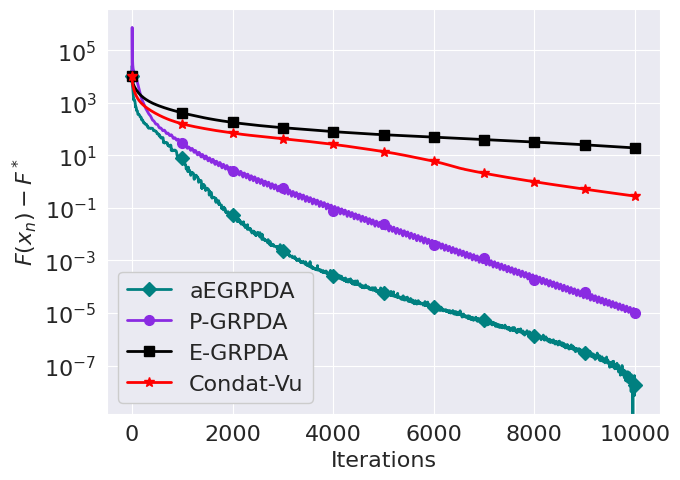

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

#1) Set seaborn style
sns.set_style('darkgrid')
plt.rcParams['legend.facecolor'] = plt.rcParams['axes.facecolor']

#2) Define plot styles via rcParams
plt.rcParams.update({
    'font.size':        13,
    'figure.figsize':   (7, 5),
    'legend.fontsize':  16,
    'lines.linewidth':  2,
    'axes.labelsize':   16,
    'axes.titlesize':   10,
    'xtick.labelsize':  16,
    'ytick.labelsize':  16,
    'xtick.major.pad':  4,
    'ytick.major.pad':  4,
})

#3) Prepare your convergence data
values = [ans4[0], ans5[0], ans1[0], ans2[0]]
labels = ['aEGRPDA', 'P‑GRPDA', 'E‑GRPDA', 'Condat-Vu']
v_min = min(min(v) for v in values)
data = [np.array(v) - v_min for v in values]
iters = np.arange(len(data[0]))

#4) Define markers and size
markers = ['D', 'o', 's', '*']
msize = 7

#5) Plot with markers
plt.figure()
for y, lbl, c, m in zip(data, labels, ['#008080','#8A2BE2','black', 'red'], markers):
    plt.plot(iters, y,
             color=c, marker=m, markersize=msize,
             markevery=max(1, len(iters)//10), label=lbl)

plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel(r'$F(x_n)-F^*$')

#6) Legend with faded box
plt.legend(framealpha=1.0)

plt.grid(True)
plt.tight_layout()
plt.savefig('log_scale_plot_comparison1.eps', dpi=700)
files.download('log_scale_plot_comparison1.eps')
plt.show()


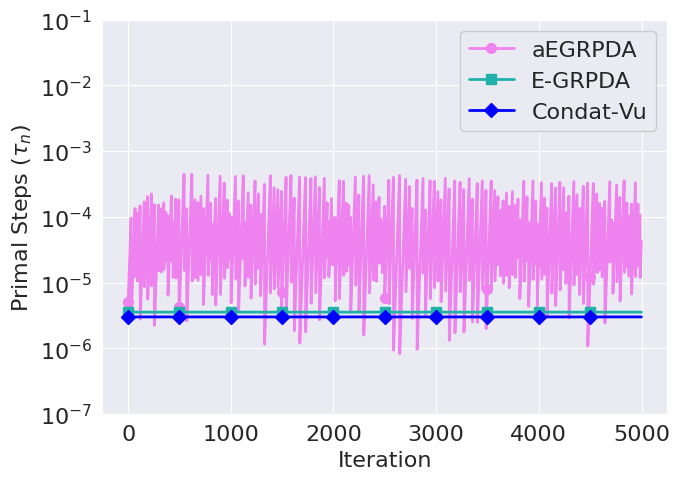

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

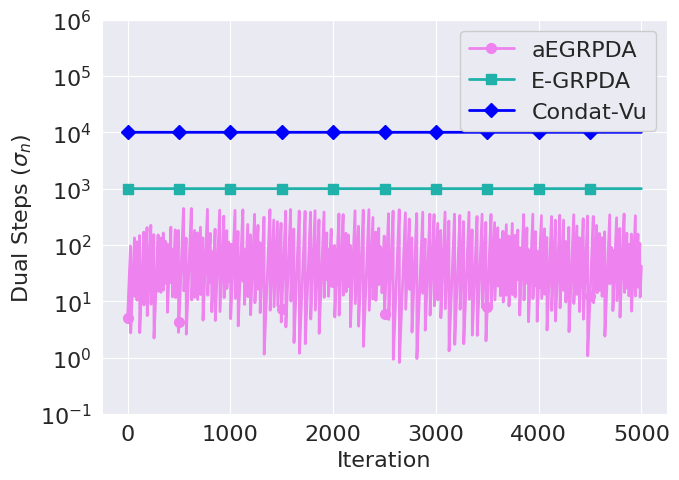

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#1) Style
sns.set_style('darkgrid')
plt.rcParams['legend.facecolor'] = plt.rcParams['axes.facecolor']
plt.rcParams.update({
    'font.size':        13,
    'figure.figsize':   (7, 5),
    'legend.fontsize':  16,
    'lines.linewidth':  2,
    'axes.labelsize':   16,
    'xtick.labelsize':  16,
    'ytick.labelsize':  16,
    'xtick.major.pad':  4,
    'ytick.major.pad':  4,
})

#2) Unpack results
_, _, _, _, sigma4, tau4 = ans4       # aEGRPDA
_, _, _, _, sigma1, tau1 = ans1       # E‑GRPDA
_, _, _, _, tau2, sigma2 = ans2       # Condat‑Vu

#3) Restrict to first 5000 iterations
max_iter = 5000

#4) Plot tau_n on log‐scale
plt.figure()
for tau_vals, label, color, marker in [
    (tau4, 'aEGRPDA',       '#EE82EE', 'o'),
    (tau1, 'E‑GRPDA',       '#20B2AA', 's'),
    (tau2, 'Condat‑Vu','blue',    'D'),
]:
    tau_plot = np.array(tau_vals)[:max_iter]
    it = np.arange(len(tau_plot))
    me = max(1, len(it)//10)
    plt.plot(it, tau_plot,
             label=rf'{label}',
             color=color,
             marker=marker,
             markersize=7,
             markevery=me)

plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'Primal Steps ($\tau_n$)')
plt.ylim([1e-7, 1e-1])
plt.legend(framealpha=1.0, loc='upper right')
plt.tight_layout()
# plt.savefig('log_scale_plot_comparison1.eps', dpi=600)
# files.download('log_scale_plot_comparison1.eps')
plt.show()

#5) Plot sigma_n on log‐scale
plt.figure()
for sigma_vals, label, color, marker in [
    (sigma4, 'aEGRPDA',       '#EE82EE', 'o'),
    (sigma1, 'E‑GRPDA',       '#20B2AA', 's'),
    (sigma2, 'Condat‑Vu',     'blue',    'D'),
]:
    sigma_plot = np.array(sigma_vals)[:max_iter]
    it = np.arange(len(sigma_plot))
    me = max(1, len(it)//10)
    plt.plot(it, sigma_plot,
             label=rf'{label}',
             color=color,
             marker=marker,
             markersize=7,
             markevery=me)

plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'Dual Steps ($\sigma_n$)')
plt.ylim([1e-1, 1e6])
plt.legend(framealpha=1.0, loc='upper right')
plt.tight_layout()
plt.savefig('log_scale_plot_comparison1.eps', dpi=600)
files.download('log_scale_plot_comparison1.eps')
plt.show()
